<a href="https://colab.research.google.com/github/saquibali7/ImageColorization/blob/main/GAN_image_colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import os.path
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from skimage.color import rgb2lab, lab2rgb
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import asarray
from PIL import Image
from os import listdir
from numpy import savez_compressed
from numpy import load
from matplotlib import pyplot


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir = '/content/drive/MyDrive/dataset/archive'
files = os.listdir(dir)

In [ ]:
len(files)

4321

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


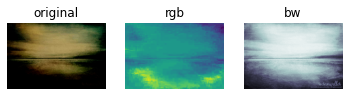

In [ ]:
from numpy.random import randint
from skimage.transform import resize

ix = randint(0, len(files))
randomImage = load_img(os.path.join(dir, files[ix]))
randomImage = img_to_array(randomImage)
orig_img = (randomImage-127.5)/127.5
randomImage = rgb2lab(randomImage)
bw_img , rgb_img = randomImage[:,:,0], randomImage[:,:,1:]/128
bw_img = bw_img.reshape(bw_img.shape+(1,))
images =  [orig_img, rgb_img, bw_img]
titles = ["original", "rgb", "bw"]
for i in range(3):
  pyplot.subplot(1,3,i+1)
  if(i==1 ):
    pyplot.imshow(images[i][:,:,0])
  elif(i==2):
    pyplot.imshow(images[i][:,:,0], cmap="bone")  
  else :
    pyplot.imshow(images[i])
  pyplot.title(titles[i])
  pyplot.axis('off')
pyplot.show()



In [ ]:
print(rgb_img.shape)
print(bw_img.shape)

(533, 800, 2)
(533, 800, 1)


In [ ]:
def load_images(path, size=(256,256)):
  rgb_list, bw_list= list(),list()
  count=0;
  for i in range(1000):
    idx = randint(0, len(files))
    pixels = load_img(os.path.join(path, files[idx]), target_size=size)
    pixels = img_to_array(pixels)
    pixels = rgb2lab(pixels)
    bw_img , rgb_img = pixels[:,:,0], pixels[:,:,1:]/128
    bw_img = bw_img.reshape(bw_img.shape+(1,))
    rgb_list.append(rgb_img)
    bw_list.append(bw_img)
  return [asarray(bw_list), asarray(rgb_list)]



In [ ]:
[bw_images, rgb_images] = load_images(dir)

In [ ]:
filename = 'train_set.npz'
savez_compressed(filename, bw_images, rgb_images)

In [ ]:
%cd /content/drive/MyDrive/dataset

/content/drive/MyDrive/dataset


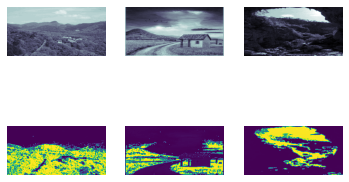

In [ ]:
from numpy import load
data = load('train_set.npz')
bw_img, rgb_img = data['arr_0'], data['arr_1']
n_samples = 3
bw_img = bw_img/255
rgb_img = (rgb_img+1)/2
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(bw_img[i][:,:,0].astype('uint8'), cmap="bone")
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off') 
	pyplot.imshow(rgb_img[i][:,:,0].astype('uint8'))
pyplot.show()

In [ ]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras import initializers
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras.layers import Concatenate


In [ ]:

def discriminator(image1_shape, image2_shape):
  bw_image = Input(image1_shape)
  rgb_image = Input(image2_shape)

  merged = Concatenate()([bw_image, rgb_image])
  d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02))(merged)
  d = LeakyReLU(alpha=0.2)(d)
  d = Conv2D(128, (4,4),  strides=(2,2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02))(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = Conv2D(256, (4,4),  strides=(2,2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02))(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02))(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = Conv2D(512, (4,4),  padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02))(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(1, (4,4), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02))(d)
  output = Activation('sigmoid')(d)

  model = Model([bw_image, rgb_image], output)
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
  return model



In [ ]:
def encoder(layer_in, n_filters, batchnorm=True):
  g = Conv2D(n_filters, (4,4), strides=(2,2),  padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02))(layer_in)
  if batchnorm:
    g=BatchNormalization()(g, training=True)
  g = LeakyReLU(alpha=0.2)(g)
  return g


def decoder(layer_in, skip_in, n_filters, dropout=True):
  g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02))(layer_in)
  g=BatchNormalization()(g, training=True)
  if dropout:
    g = Dropout(0.5)(g, training=True)
  g = Concatenate()([g, skip_in])
  g = Activation('relu')(g)
  return g  

def generator(image_shape=(256,256,1)):
  in_image = Input(image_shape)
  e1 = encoder(in_image, 64,batchnorm=False)
  e2 = encoder(e1, 128)
  e3 = encoder(e2, 256)
  e4 = encoder(e3, 512)
  e5 = encoder(e4, 512)
  e6 = encoder(e5, 512)
  e7 = encoder(e6, 512)

  b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02))(e7)
  b = Activation('relu')(b)

  d1 = decoder(b, e7, 512)
  d2 = decoder(d1, e6, 512)
  d3 = decoder(d2, e5, 512)
  d4 = decoder(d3, e4, 512, dropout=False)
  d5 = decoder(d4, e3, 256, dropout=False)
  d6 = decoder(d5, e2, 128, dropout=False)
  d7 = decoder(d6, e1, 64, dropout=False)

  g = Conv2DTranspose(2, (4,4), strides=(2,2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02))(d7)
  out_image= Activation('tanh')(g)

  model = Model(in_image, out_image)
  return model

In [ ]:
def gan_model(g_model, d_model, input_shape):
  for layer in d_model.layers:
    if not isinstance(layer, BatchNormalization):
      layers.trainable=False
  in_img = Input(input_shape)
  gen_output = g_model(in_img)
  dis_output = d_model([in_img, gen_output])
  model = Model(in_img, [dis_output, gen_output])
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
  return model



In [ ]:
def load_samples(filename):
  data = load(filename)
  X1, X2 = data['arr_0'], data['arr_1']
  X1 = (X1 - 127.5) / 127.5
  X2 = (X2 - 127.5) / 127.5

  return [X1, X2]


In [ ]:
def real_samples(data, n_samples, patch_shape):
  trainA, trainB = data
  idx = randint(0, trainA.shape[0], n_samples)
  X1, X2 = trainA[idx], trainB[idx]
  y = ones((n_samples, patch_shape, patch_shape, 1))
  return [X1, X2], y

In [ ]:
def fake_samples(g_model, samples, patch_shape):
  X = g_model.predict(samples)
  y = zeros((len(X), patch_shape, patch_shape, 1))
  return X, y



In [ ]:
def summarize_performance(step, g_model, dataset, n_samples=3):
  [X_realA, X_realB]= real_samples(dataset, n_samples, 1)
  X_fakeB, _ = fake_samples(g_model, X_realA, 1)
  X_realA = (X_realA+1)/2.0
  X_reakB = (X_realB+1)/2.0
  X_fakeB = (X_fakeB+1)/2.0

  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1+i)
    pyplot.axis("off")
    pyplot.imshow(X_realA[i][:,:,0])

  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1+n_samples+i)
    pyplot.axis("off")
    pyplot.imshow(X_fakeB[i][:,:,0])

  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1+n_samples*2+i)
    pyplot.axis("off")
    pyplot.imshow(X_realB[i][:,:,0])    

  filename1 = 'plot_%06d.png' % (step+1)
  pyplot.savefig(filename1)
  pyplot.close() 
  filename2 = 'model_%06d.h5' % (step+1) 
  g_model.save(filename2)
  print('>Saved: %s and %s' % (filename1, filename2))  

In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
  n_patch = d_model.output_shape[1]
  trainA, trainB = dataset
  batch_per_epoch = int(len(trainA)/n_batch)
  n_steps = batch_per_epoch * n_epochs
  for i in range(n_steps):
    [X_realA, X_realB], y_real = real_samples(dataset, n_batch, n_patch)
    X_fakeB, y_fake = fake_samples(g_model, X_realA, n_patch)
    d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
    d_loss2 = d_model.train_on_batch([X_realA, X_realB], y_fake)
    g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
    print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
    if (i+1) % (batch_per_epoch * 10) == 0:
      summarize_performance(i, g_model, dataset)


In [ ]:
dataset = load_samples('train_set.npz')
bw_shape = dataset[0].shape[1:]
rgb_shape = dataset[1].shape[1:]

In [ ]:
print(bw_shape)
print(rgb_shape)

(256, 512, 1)
(256, 512, 2)


In [ ]:
d_model = discriminator(bw_shape,rgb_shape)
g_model =  generator(bw_shape)
gan_model = gan_model(g_model, d_model, bw_shape)
train(d_model, g_model, gan_model, dataset)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


TypeError: ignored

In [ ]:
print(image_shape)
print(img2_shape)

(256, 512, 1)
(256, 512, 2)
